<a href="https://colab.research.google.com/github/jimmyshah83/deep_learning/blob/master/GAN_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

GAN Using Keras

In [0]:
#import tensorflow as tf
#tf.enable_eager_execution()

In [0]:
#from google.colab import drive
#drive.mount('/content/drive')

In [0]:
from __future__ import absolute_import, division, print_function

In [0]:
import os
import time
import numpy as np
from glob import glob
import datetime
import random
from PIL import Image
import matplotlib.pyplot as plt
import time

import tensorflow as tf
from tensorflow.keras import layers

%matplotlib inline

Image size used as 24 as training was taking a long time for an Image f size 128. Model adjusted accordingly

In [0]:
# Hyperparameters
IMAGE_SIZE = 28
NOISE_SIZE = 100
BATCH_SIZE = 32
EPOCHS = 50
BETA1 = 0.5
EPSILON = 0.00005
BUFFER_SIZE = 9000

In [0]:
train_images = np.asarray([np.asarray(Image.open(file).resize((IMAGE_SIZE, IMAGE_SIZE))) 
                           for file in glob('drive/My Drive/images/' + '10*.png')])

In [464]:
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]
print ("Input: " + str(train_images.shape))

Input: (111, 28, 28, 3)


In [0]:
train_images = train_images.astype('float32')

In [0]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images)
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
#train_dataset = get_batches(train_images)

In [0]:
def make_generator_model():
    model = tf.keras.Sequential()
    
    model.add(layers.Dense(8*8*1024, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization(epsilon=EPSILON))
    model.add(layers.LeakyReLU())
    
    model.add(layers.Reshape((8, 8, 1024)))
    assert model.output_shape == (None, 8, 8, 1024)
    
    model.add(layers.Conv2DTranspose(512, (5, 5), padding='same', use_bias=False))
    model.add(layers.BatchNormalization(epsilon=EPSILON))
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(256, (5, 5), padding='same', use_bias=False))
    model.add(layers.BatchNormalization(epsilon=EPSILON))
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(128, (5, 5), padding='same', use_bias=False))
    model.add(layers.BatchNormalization(epsilon=EPSILON))
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(64, (5, 5), padding='same', use_bias=False))
    model.add(layers.BatchNormalization(epsilon=EPSILON))
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(3, (5, 5), padding='same', use_bias=False))
    
    return model

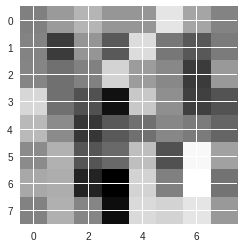

In [468]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])

generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [0]:
def make_discriminator_model():
  model = tf.keras.Sequential()
  
  model.add(layers.Conv2D(64, (5, 5), padding='same', strides=(2, 2)))
  model.add(layers.BatchNormalization(epsilon=EPSILON))
  model.add(layers.LeakyReLU())
    
  model.add(layers.Conv2D(128, (5, 5), padding='same', strides=(2, 2)))
  model.add(layers.BatchNormalization(epsilon=EPSILON))
  model.add(layers.LeakyReLU())
    
  model.add(layers.Conv2D(256, (5, 5), padding='same', strides=(2, 2)))
  model.add(layers.BatchNormalization(epsilon=EPSILON))
  model.add(layers.LeakyReLU())
              
  model.add(layers.Conv2D(512, (5, 5), padding='same', strides=(2, 2)))
  model.add(layers.BatchNormalization(epsilon=EPSILON))
  model.add(layers.LeakyReLU())
              
  model.add(layers.Conv2D(1024, (5, 5), padding='same', strides=(2, 2)))
  model.add(layers.BatchNormalization(epsilon=EPSILON))
  model.add(layers.LeakyReLU())
              
  model.add(layers.Flatten())
  model.add(layers.Dense(1, activation='sigmoid'))
              
  return model

In [470]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)
decision.shape

tf.Tensor([[0.49999738]], shape=(1, 1), dtype=float32)


TensorShape([Dimension(1), Dimension(1)])

In [0]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [0]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [0]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [0]:
discriminator_optimizer = Adam(lr=LR_D, beta_1=BETA1)
generator_optimizer = Adam(lr=LR_G, beta_1=BETA1)

In [0]:
seed = tf.random.normal([16, 100])

In [0]:
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_SIZE])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)
    
      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

In [0]:
def train(dataset):  
  for epoch in range(EPOCHS):
    start = time.time()
    
    for image_batch in dataset:
      train_step(image_batch)
      
    # Produce images for the GIF as we go
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)
    
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

In [0]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False. 
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))
  
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
  plt.show()

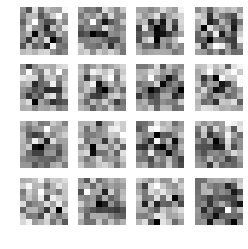

Time for epoch 1 is 2.6460466384887695 sec


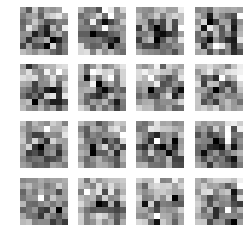

Time for epoch 2 is 2.122422695159912 sec


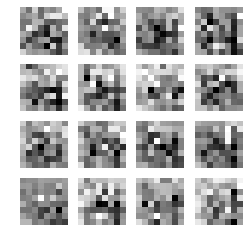

Time for epoch 3 is 2.126988649368286 sec


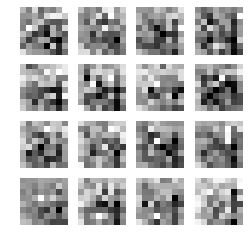

Time for epoch 4 is 2.09796142578125 sec


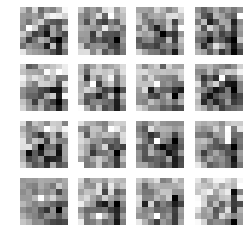

Time for epoch 5 is 2.1047048568725586 sec


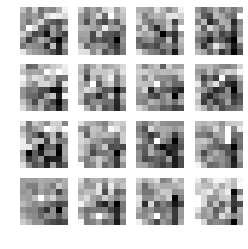

Time for epoch 6 is 2.0778768062591553 sec


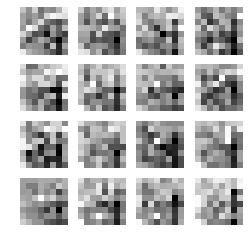

Time for epoch 7 is 2.102492094039917 sec


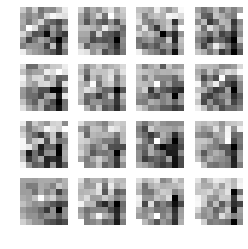

Time for epoch 8 is 2.116058349609375 sec


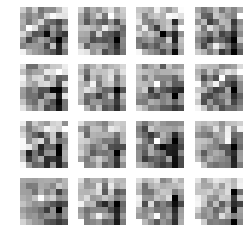

Time for epoch 9 is 2.1725618839263916 sec


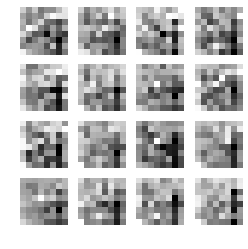

Time for epoch 10 is 2.1511483192443848 sec


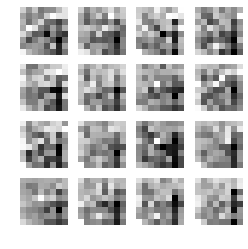

Time for epoch 11 is 2.1469759941101074 sec


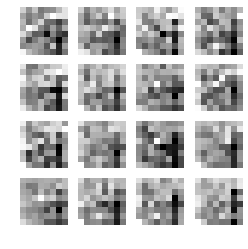

Time for epoch 12 is 2.572260856628418 sec


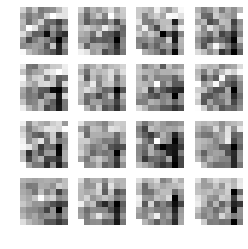

Time for epoch 13 is 2.112718343734741 sec


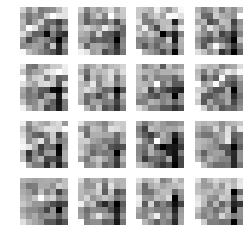

Time for epoch 14 is 2.1211001873016357 sec


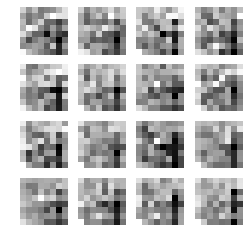

Time for epoch 15 is 2.1236209869384766 sec


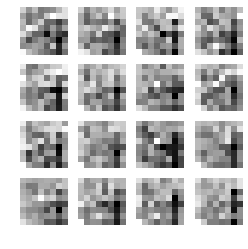

Time for epoch 16 is 2.141382932662964 sec


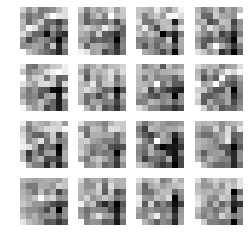

Time for epoch 17 is 2.0917649269104004 sec


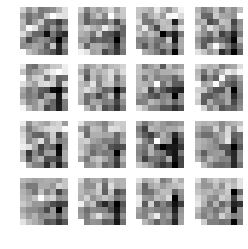

Time for epoch 18 is 2.100008249282837 sec


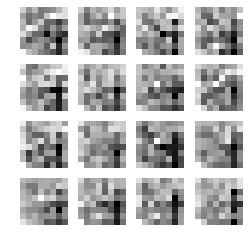

Time for epoch 19 is 2.0718767642974854 sec


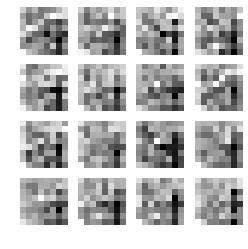

Time for epoch 20 is 2.0879201889038086 sec


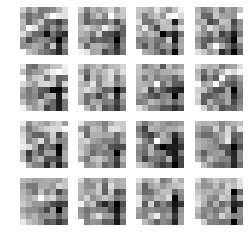

Time for epoch 21 is 2.100306510925293 sec


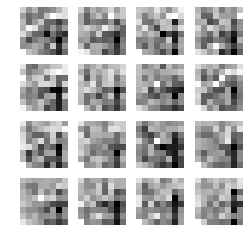

Time for epoch 22 is 2.168450355529785 sec


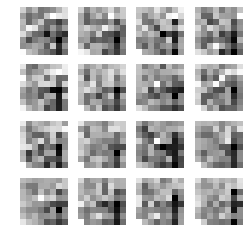

Time for epoch 23 is 2.1532363891601562 sec


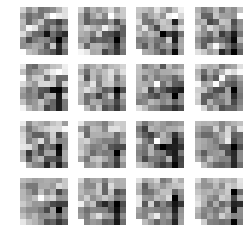

Time for epoch 24 is 2.5898382663726807 sec


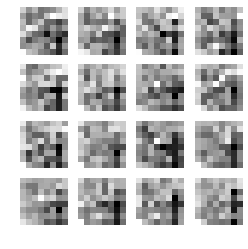

Time for epoch 25 is 2.1190640926361084 sec


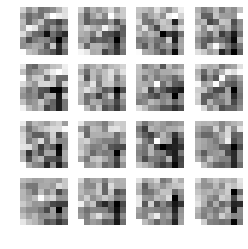

Time for epoch 26 is 2.1207644939422607 sec


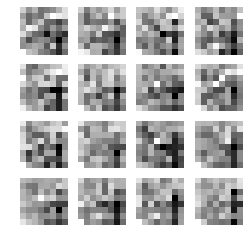

Time for epoch 27 is 2.127586603164673 sec


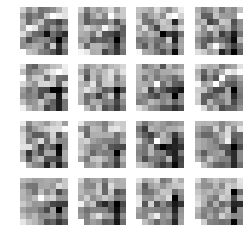

Time for epoch 28 is 2.123386859893799 sec


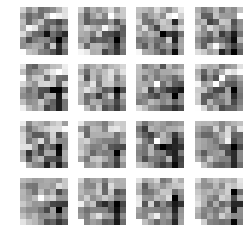

Time for epoch 29 is 2.155299663543701 sec


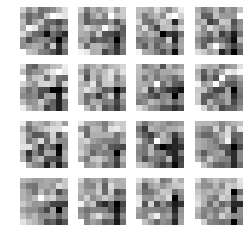

Time for epoch 30 is 2.1162564754486084 sec


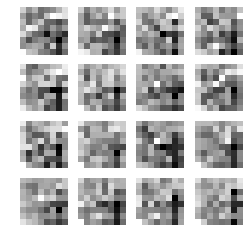

Time for epoch 31 is 2.113487958908081 sec


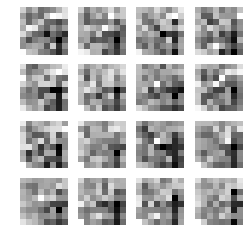

Time for epoch 32 is 2.1262552738189697 sec


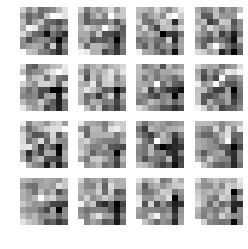

Time for epoch 33 is 2.122248411178589 sec


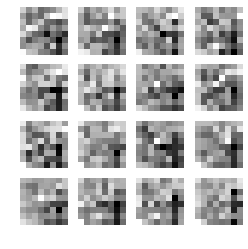

Time for epoch 34 is 2.1355464458465576 sec


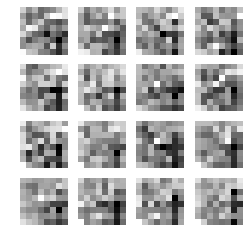

Time for epoch 35 is 2.588533878326416 sec


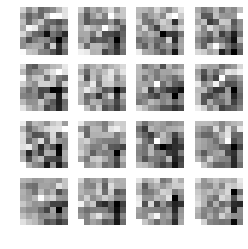

Time for epoch 36 is 2.124898672103882 sec


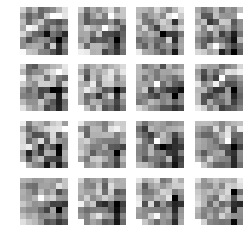

Time for epoch 37 is 2.126019239425659 sec


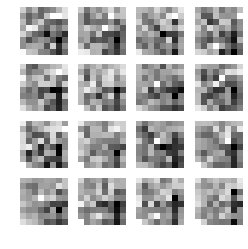

Time for epoch 38 is 2.133188486099243 sec


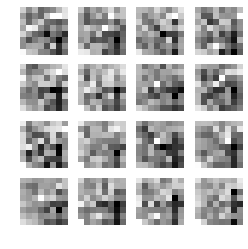

Time for epoch 39 is 2.1136951446533203 sec


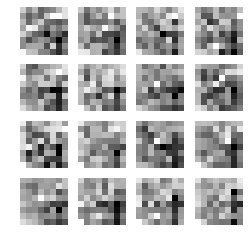

Time for epoch 40 is 2.127993583679199 sec


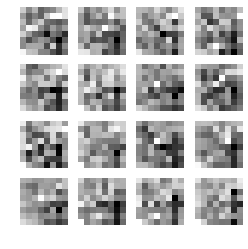

Time for epoch 41 is 2.1173465251922607 sec


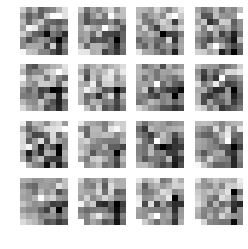

Time for epoch 42 is 2.102330446243286 sec


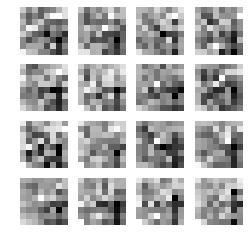

Time for epoch 43 is 2.100959062576294 sec


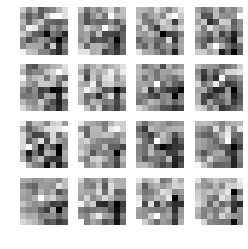

Time for epoch 44 is 2.0952956676483154 sec


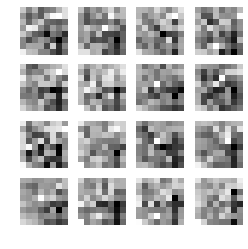

Time for epoch 45 is 2.098449230194092 sec


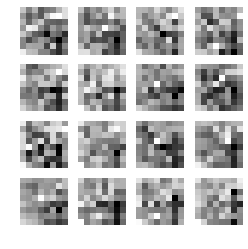

Time for epoch 46 is 2.131317138671875 sec


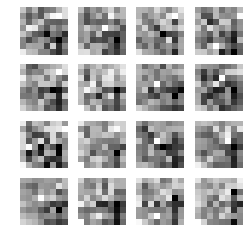

Time for epoch 47 is 2.5818891525268555 sec


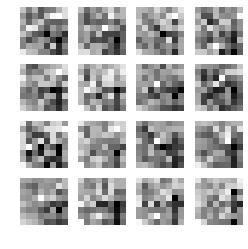

Time for epoch 48 is 2.1316514015197754 sec


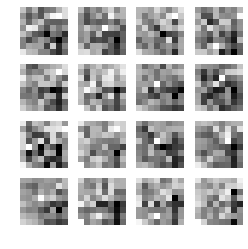

Time for epoch 49 is 2.1205930709838867 sec


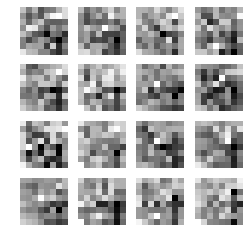

Time for epoch 50 is 2.116096019744873 sec


In [479]:
train(train_dataset)